### CONFIGURATION

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [3]:
#CHROM SLICING
minChromFrac = 0#17.443476
maxChromFrac = 200#17.491846

#minChromFrac = 17.689695
#maxChromFrac = 17.73896

In [4]:
# BED FILE
USE_BED = True
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
#BED_PATH = "/Users/peterpriestley/hmf/analyses/dreamChallenge/"
#BED_FILE_NAME= "dream3msk.bed"

# TRUTH SET
SAMPLE_NAMES_TRUTH = {'SPIKEIN':'70-30truth'}
VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/dreamChallenge/"
#VCF_FILE_NAME_TRUTH = "dreamsmc.IS1.updateSV.truthSORTED.vcf"
VCF_FILE_NAME_TRUTH = "synthetic.challenge.set3.tumor.20pctmasked.truth.vcf"

# COMBINED VCF CONFIG
#VCF_SAMPLE = "synthetic.challenge.set1"
VCF_SAMPLE = "IS3.snv.indel.sv"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/dreamChallenge/"
#VCF_FILE_NAME = "synthetic.challenge.set1.normal.v2_synthetic.challenge.set1.tumor.v2_merged_somatics.vcf"
VCF_FILE_NAME = "G15512.prenormal.sorted_IS3.snv.indel.sv_merged_somatics.vcf"
#VCF_FILE_NAME = "fpDream3dbSNP.vcf"
SAMPLE_NAMES = {VCF_SAMPLE + '.mutect':'mutect', \
                VCF_SAMPLE + '.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', \
                'TUMOR.varscan':'varscan'}

#MELT PARAMS
#VCF_FILE_NAME = "G15512.prenormal.sorted_IS3.snv.indel.sv_merged_somatics_annotated_melted.vcf"
#SAMPLE_NAMES = {'IS3.snv.indel.sv':'melted'}

### Functions

In [5]:
def filterByChromFrac(df):
    return df[(df.chromFrac > minChromFrac)&(df.chromFrac < maxChromFrac)]

In [6]:
def calculateTruth(df,dfTruth):
    df = pd.merge(df,dfTruth,how='left', left_index=True,right_index=True,suffixes=('', '_Truth'))
    df['hasTP'] =  ~pd.isnull(df['ref_Truth'])#False
    df['hasFP'] = False
#    for columnName in list(df):
#        if columnName.endswith('allele'):
#            df['hasTP'] = (df['hasTP']) | ((df[columnName[:-6]+'indelDiff'] == df['truth_indelDiff']) \
#                    & (~pd.isnull(df['truth_indelDiff']) & (df['variantType'] == 'INDEL'))) |((df[columnName] == df['truth_allele']) \
#                    & (df['variantType'] == 'SNP'))
#            df['hasFP'] = (df['hasFP']) | ((df[columnName[:-6]+'indelDiff'] != df['truth_indelDiff']) \
#                    & (df['variantType'] == 'INDEL') & (df[columnName[:-6]+'indelDiff'] != '')) |((df[columnName] != df['truth_allele']) \
#                    & (df['variantType'] == 'SNP') & (df[columnName] != ''))
    df['Truth'] = (df['hasTP'])  # &  (df['hasFP'] == False)
    return df

In [7]:
def calcuatePrecisionSensivityMatrix(df):
    outputdata = []
    for columnName in list(df):
        if columnName.endswith('allele') & ~columnName.endswith('_allele'):
            myCaller = columnName[:-6]
            variantTypes = df[(df[myCaller+'allele'] != '')].variantType.unique()
            for variantType in variantTypes:
                truePositives = len(df[(df[myCaller+'allele'] != '') & (df['Truth'] == True) &(df['variantType'] == variantType)])
                positives = len(df[(df[myCaller+'allele'] != '')&(df['variantType'] == variantType)])
                truthSet = len(dfTruth[dfTruth['variantType'] == variantType]) 
                falseNegatives = truthSet - truePositives
                if positives > 0:
                    outputdata.append([variantType, myCaller, truthSet,truePositives,positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(max(truthSet,1)),4)])
    
    outputDF = pd.DataFrame(outputdata)
    outputDF.columns = (['variantType','caller','truthSet','truePositives','falsePositives','falseNegatives','precision','sensitivity'])
    return outputDF.sort_values(['variantType','caller'])

<h3> Load VCFs and Prepare DF

In [8]:
## LOAD TRUTH SET VCF
if USE_BED:
    bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
    dfTruth = aVCF.loadVariantsFromVCF(VCF_PATH_TRUTH,VCF_FILE_NAME_TRUTH,SAMPLE_NAMES_TRUTH,"Mix-in Truth Set",True,True,bed,True)
else:
    dfTruth = aVCF.loadVariantsFromVCF(VCF_PATH_TRUTH,VCF_FILE_NAME_TRUTH,SAMPLE_NAMES_TRUTH,"Mix-in Truth Set",False,True)
dfTruth = filterByChromFrac(dfTruth)
dfTruth.rename(columns={'70-30truthallele':'truth_allele','70-30truthindelDiff':'truth_indelDiff'}, inplace=True)
dfTruth = dfTruth[['chrom','pos','variantType','ref','truth_allele','truth_indelDiff']]
dfTruth = dfTruth.set_index(['chrom','pos'])

reading vcf file: synthetic.challenge.set3.tumor.20pctmasked.truth.vcf
reading VCF File line: 1
Number variants loaded: 22266


In [9]:
# LOAD SAMPLE VCF + match to truth set
if USE_BED:
    bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
    df = aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,False,True,bed,True)
else:
    df = aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,False)
df = filterByChromFrac(df)
df = df.set_index(['chrom','pos'])
df = calculateTruth(df,dfTruth)

reading vcf file: G15512.prenormal.sorted_IS3.snv.indel.sv_merged_somatics.vcf
reading VCF File line: 1
Number variants loaded: 34598


### PON

In [13]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','ref','alt','PONCount']
    return dfPON

In [11]:
#dfPON = aVCF.loadPON("/Users/peterpriestley/hmf/analyses/PON/","PON.tsv")
dfPON = loadPON("/Users/peterpriestley/hmf/analyses/PON/779filePON/","PON.tsv")
# TEMPORARTY HACK - cannot easily match INDELS otherwise
dfPON = dfPON.drop_duplicates(['chrom','pos'])

In [14]:
len(dfPON)

27194811

In [19]:
df= df.reset_index()
df = pd.merge(df,dfPON,how='left', on=['chrom','pos'])
df['PONCount'].fillna(0, inplace=True)
df['inPON'] = pd.to_numeric(df.PONCount,errors=coerce)>0

### PRECISION + SENSITIVITY

In [82]:
#PRECISION + SENSITIVITY by caller - PROD
outputDF = calcuatePrecisionSensivityMatrix(df)
outputDF

,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,precision,sensitivity
5,INDEL,freebayes,6321,3129,5486,3192,0.3632,0.4950
0,INDEL,strelka,6321,3176,48,3145,0.9851,0.5025
2,INDEL,varscan,6321,2759,2769,3562,0.4991,0.4365
6,SNP,freebayes,6207,5738,5404,469,0.5150,0.9244
4,SNP,mutect,6207,5779,2182,428,0.7259,0.9310
1,SNP,strelka,6207,5051,382,1156,0.9297,0.8138
3,SNP,varscan,6207,5169,2601,1038,0.6653,0.8328


In [37]:
df['inPON'] = pd.to_numeric(df.PONCount,errors=coerce)>=4

In [39]:
pd.pivot_table(df[(df.consensus==True)], values='pos', index=['variantType'], columns=['Truth','inPON'], aggfunc='count')

Truth       False       True       
inPON       False True  False True 
variantType                        
INDEL         126   505  4003    16
SNP           350    88  7220    21

### Scratch

In [ ]:
dftemp['chrom']=pd.to_numeric(dftemp['chrom'],'coerce')
dftemp['pos']=pd.to_numeric(dftemp['pos'],'coerce')
dftemp.sort_values(['chrom','pos'])
dftemp['nextPos'] = -dftemp['pos']+dftemp['pos'].shift(-1)
dftemp['prevPos'] = dftemp['pos']-dftemp['pos'].shift(1)

In [ ]:
len(dftemp[((dftemp['prevPos']<0)|(dftemp['prevPos']>100))&((dftemp['nextPos']<0)|(dftemp['nextPos']>100))&(dftemp['variantType']=="SNP")&(dftemp['Truth']==False)&(dftemp.numCallers==2)])

In [ ]:
#pd.set_option('display.max_rows', 500)
#dftemp = df[(df['variantType']== "SNP")].reset_index()
#pd.pivot_table(dftemp, values='pos', index=['filter'], columns=['Truth','numCallers'], aggfunc='count')

# False Negative Analysis

In [ ]:
pd.options.display.max_rows = 200
caller = "varscan"
df[(df.Truth == True) &(df[caller+'allele'] != '') & (df.variantType == 'INDEL')][['ref',caller+'indelDiff',caller+'QS',caller+'AF','numCallers']]

In [ ]:
dfSlice[(dfSlice['Truth'] == True) & (dfSlice['freebayesallele'] != '') & (dfSlice.variantType == 'INDEL')]

In [ ]:
unfilteredBed = copy.deepcopy(bed)

In [ ]:
# SETTINGS
myCaller = 'varscan'
UNFILTERED_VCF_PATH = "/Users/peterpriestley/hmf/70-30slice/"
if myCaller == 'varscan':
    UNFILTERED_VCF_FILE_NAME = "varscan.snp.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'freebayes':
    UNFILTERED_VCF_FILE_NAME = "freebayes.somatic.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}  
elif myCaller == 'strelka':
    UNFILTERED_VCF_FILE_NAME = "/strelka/results/all.somatic.snvs.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'mutect':
    UNFILTERED_VCF_FILE_NAME = "mutect.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}


dfUnfiltered = aVCF.loadVaraintsFromVCF(UNFILTERED_VCF_PATH,UNFILTERED_VCF_FILE_NAME,UNFILTERED_SAMPLE_NAMES,VCF_SAMPLE,False,True,unfilteredBed)
dfUnfiltered['Truth']=dfUnfiltered.chromPos.isin(dfTruth['chromPos']) 
dfUnfiltered = dfUnfiltered[(dfUnfiltered.chromFrac > minChromFrac)&(dfUnfiltered.chromFrac < maxChromFrac)]

In [ ]:
dfTruth['inUnfiltered'+myCaller]=dfTruth.chromPos.isin(dfUnfiltered[dfUnfiltered[myCaller+'allele'] != '']['chromPos'])
dfTruth['inSlice']=dfTruth.chromPos.isin(dfSlice['chromPos'])

In [ ]:
#False Positives - pre-somatic
dfTruth[['inSlice','pos','inUnfiltered'+myCaller,'variantType']].groupby(['variantType','inUnfiltered'+myCaller]).agg('count')

In [ ]:
dfUnfiltered['inSlice'+myCaller]=dfUnfiltered.chromPos.isin(dfSlice[dfSlice[myCaller+'allele'] != '']['chromPos'])
dfUnfiltered['inSlice']=dfUnfiltered.chromPos.isin(dfSlice['chromPos'])

In [ ]:
dfUnfiltered[['inSlice'+myCaller,'pos','Truth','variantType','filter']].groupby(['variantType','inSlice'+myCaller,'Truth','filter']).agg('count')

In [ ]:
dfUnfiltered[(dfUnfiltered['Truth'] == True)&
            (dfUnfiltered['inSlice'+myCaller] == True)& 
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'PETE')]['pos']

In [ ]:
#FALSE NEGATIVES IN UNFILTERED
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == False)& 
             (dfUnfiltered[myCaller+'somaticGT'] != '2')&
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'str10')].sort_values([myCaller+'QS'],ascending=False)

In [ ]:
dfSlice[dfSlice.pos>'37577400'].head(10)

In [ ]:
#FALSE POSITIVES`
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == True) & (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['Truth'] == False)].sort_values([myCaller+'QS'],ascending=False)

<h3> SNP

In [ ]:
snpdf = df[(df.variantType == 'SNP')]

In [ ]:
snpdf[['Truth','pos']].groupby(['Truth']).agg('count')

In [ ]:
pd.pivot_table(snpdf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

In [ ]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Indel Venn

In [ ]:
indeldf= df[(df.variantType == 'INDEL')]

In [ ]:
pd.pivot_table(indeldf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

In [ ]:
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Read Depth

In [ ]:
for columnName in list(df):
    if columnName.endswith('allelicFreq'):
        df[df[columnName] != ''].hist(column=columnName,by="Truth",bins=40,figsize=(10,5))

In [ ]:
df[df.freebayesreadDepth != ''].hist(column="freebayesallelicFreq",by="Truth",bins=30)

In [ ]:
# INDELS BY CALLER BY TRUTH
caller = 'freebayes'
truths = indeldf.Truth.unique()
for truth in truths:
    ser = indeldf[(indeldf.Truth == truth) &(indeldf[caller+'allele'] != '')][caller + 'QS']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=caller+" INDEL "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=caller+" Qual Score CDF - INDELS",figsize=[15,6], xlim=[0,100],ylim=[0,1])

truths = snpdf.Truth.unique()
for truth in truths:
    ser = snpdf[(snpdf.Truth == truth) &(snpdf[caller+'allele'] != '')][caller + 'QS']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=caller+" SNP "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=caller+"Qual Score CDF",figsize=[15,6],xlim=[0,100],ylim=[0,1])

In [ ]:
pd.set_option('display.max_rows', 1000)
snpdf['chromPos'].reset_index().head(1000)

<h3> Allelic Depth

strelkaallele
strelkaallele
varscanallele
varscanallele
mutectallele
mutectallele
freebayesallele
freebayesallele


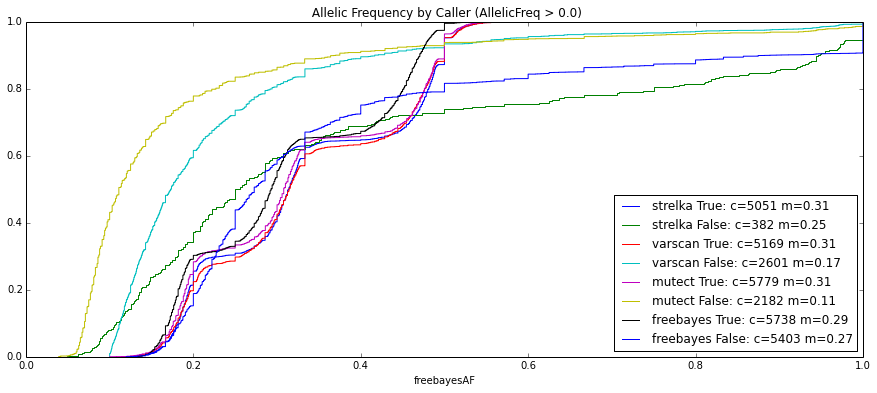

In [89]:
#Alllele Freq By Caller
snpdf = df[(df.variantType == 'SNP')]
#snpdf = dftemp[(dftemp.variantType == "SNP")&(dftemp.inDBSNP == False)&(dftemp.Truth == False)&(dftemp.numCallers == 2)]
for columnName in list(snpdf):
    for Truth in [True,False]:
        if columnName.endswith('allele') and not columnName.startswith('truth'):# and not columnName.startswith('mut'):
            print columnName
            ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0.0)&(snpdf.Truth==Truth)][columnName[:-6] + 'AF']
            ser = ser.sort_values()
            #ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+" "+ str(Truth) +": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[15,6],xlim=[0,1])

In [ ]:
# BY CALLER BY TRUTH
truths = snpdf.Truth.unique()
for truth in truths:
    for columnName in list(snpdf):
        if columnName.endswith('allele'):
            ser = snpdf[(snpdf.Truth == truth) &(snpdf[columnName] != '')][columnName[:-6] + 'allelicFreq']
            ser = ser.sort_values()
            #ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+" "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller and Truth",figsize=[15,6])

In [ ]:
#  BY VENN SEGMENT - Single Caller - FALSE POSITIVES
myCaller = 'freebayes'
vennSegments = snpdf[(snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False)].vennSegment.unique()
for vennSegment in vennSegments:
    ser = snpdf[(snpdf.vennSegment == vennSegment) & (snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False) ][myCaller+'allelicFreq']
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" FP by Venn Segment",figsize=[15,6])

### Allelic Depth Scatter Plot

In [ ]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])

<h3> RAINBOW CHARTS

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

<h3> Overlapping Analysis

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
sorteddf = df.sort(['chromFrac'], ascending=1)
sorteddf['nextRef'] = sorteddf['ref'].shift(-2)
sorteddf['nextPos'] = sorteddf['pos'].shift(-2)
sorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)
sorteddf['nextVT'] = sorteddf['variantType'].shift(-2)
sorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)
sorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)
sorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)
sorteddf['lengthRef'] = sorteddf['ref'].str.len()
sorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)

overlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]
overlapdf.head(20)
'''

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
filtereddf = overlapdf[(~overlapdf.vennSegment.isin(['freebayes','varscan','strelka1'])) \
                       & (overlapdf.vennSegment.str.contains('varscan')) \
                       #& (~overlapdf.nextVennSegment.str.contains('varscan')) \
                       & (overlapdf.variantType == 'INDEL') \
                       #& (overlapdf.variantSubType == 'DELETE')
                       & (overlapdf.variantType == overlapdf.nextVT)]
filtereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2', \
            'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()
'''

In [123]:
df.head(1)

,level_0,index,chrom,pos,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,bedRegion,inDBSNP,inCOSMIC,annGene,annWorstImpact,annWorstEffect,annAllEffects,consensus,strelkaallele,strelkaAF,strelkaDP,strelkaQS,strelkaSGT,strelkaindelDiff,varscanallele,varscanAF,varscanDP,varscanQS,varscanSGT,varscanindelDiff,mutectallele,mutectAF,mutectDP,mutectQS,mutectSGT,mutectindelDiff,freebayesallele,freebayesAF,freebayesDP,freebayesQS,freebayesSGT,freebayesindelDiff,patientName,variantType_Truth,ref_Truth,truth_allele,truth_indelDiff,hasTP,hasFP,Truth,PONCount,inPON
0,0,0,1,100027355,1:100027355,1.401312,.,AT,strelka-varscan-freebayes,3,INDEL,DELETE,PASS,Default,False,False,,,,,True,A,0.347826,27,41,ref->het,T-,A,0.3077,26,35,2,T-,,,,,,,A,0.32,25,121.62,0/1,T-,IS3.snv.indel.sv,INDEL,AT,A,T-,True,False,True,0,False


In [137]:
#df = df.reset_index()
df[(df.chromFrac>1.04)&(df.chromFrac<1.05)][['chrom','pos','variantType','numCallers','vennSegment','inPON','Truth']].head(20)

,chrom,pos,variantType,numCallers,vennSegment,inPON,Truth
9,1,10076644,INDEL,1,freebayes,True,False
12,1,10108703,SNP,4,Intersection,False,True
14,1,10135617,SNP,4,Intersection,False,True
16,1,10144922,INDEL,1,freebayes,False,False
28,1,10274033,INDEL,1,freebayes,True,False
30,1,10296364,SNP,1,varscan,True,False
39,1,10380773,INDEL,1,freebayes,True,False
41,1,10419133,SNP,4,Intersection,False,True
46,1,10465482,SNP,1,mutect,True,False
69,1,10679372,INDEL,1,varscan,True,False
